In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

In [2]:
# normalization transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
# load datasets
train_data = torchvision.datasets.CIFAR10(root='../data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4,
                                          shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(root='../data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4,
                                          shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

 frog  deer   dog  ship


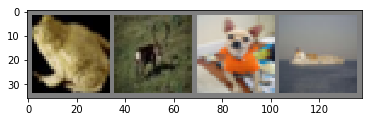

Process Process-1:
Process Process-2:
Traceback (most recent call last):
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue

In [6]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Define the CNN

In [7]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5,5))
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5,5))
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
net = CNN()

In [9]:
import torch.optim as optim

In [10]:
error_fun = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training the network

In [12]:
for epoch in range(2):
    
    running_loss = 0.0
    
    for i, batch in enumerate(trainloader, 1):
        x, labels = batch
        
        optimizer.zero_grad()
    
        output = net.forward(x)
        loss = error_fun(output, labels)
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()
        if i % 2000 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i, running_loss / 2000))
            
            running_loss = 0.0

print('Done training')   

[1,  2000] loss: 1.413
[1,  4000] loss: 1.377
[1,  6000] loss: 1.337
[1,  8000] loss: 1.327
[1, 10000] loss: 1.307
[1, 12000] loss: 1.303
[2,  2000] loss: 1.239
[2,  4000] loss: 1.227
[2,  6000] loss: 1.245
[2,  8000] loss: 1.227
[2, 10000] loss: 1.198
[2, 12000] loss: 1.178
Done training


# Test learned parameters

GroundTruth:    cat  ship  ship plane


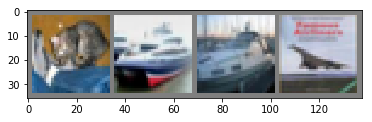

In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [14]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 74 %
Accuracy of   car : 73 %
Accuracy of  bird : 38 %
Accuracy of   cat : 46 %
Accuracy of  deer : 47 %
Accuracy of   dog : 23 %
Accuracy of  frog : 61 %
Accuracy of horse : 62 %
Accuracy of  ship : 70 %
Accuracy of truck : 63 %
